In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os,re,glob,cv2
import PIL
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from tensorflow import keras

In [ ]:
image_datas = glob.glob('/content/drive/MyDrive/CV/mini_dataset/*/*.png')
categories = ["spring","summer","autumn","winter"] 
dic = {"spring":0,"summer":1,"autumn":2,"winter":3}

image_w = 64
image_h = 64

X = []
Y = []

for imagename in image_datas:
  image = Image.open(imagename)
  image = image.resize((128,128))
  image = np.array(image)
  X.append(image)
  label = imagename.split('/')[6]
  label = dic[label]
  Y.append(label)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y,test_size=0.1, shuffle=True, random_state=44)

train_labels = train_labels[...,tf.newaxis]
test_labels = test_labels[...,tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((635, 128, 128, 3), (635, 1), (71, 128, 128, 3), (71, 1))

In [ ]:
# train data class별 image 수
unique, counts = np.unique(np.reshape(train_labels,(635,)),axis=-1, return_counts=True)
dict(zip(unique,counts))

{0: 163, 1: 176, 2: 137, 3: 159}

In [ ]:
# test data class별 image 수
unique, counts = np.unique(np.reshape(test_labels,(71,)),axis=-1, return_counts=True)
dict(zip(unique,counts))

{0: 19, 1: 16, 2: 14, 3: 22}

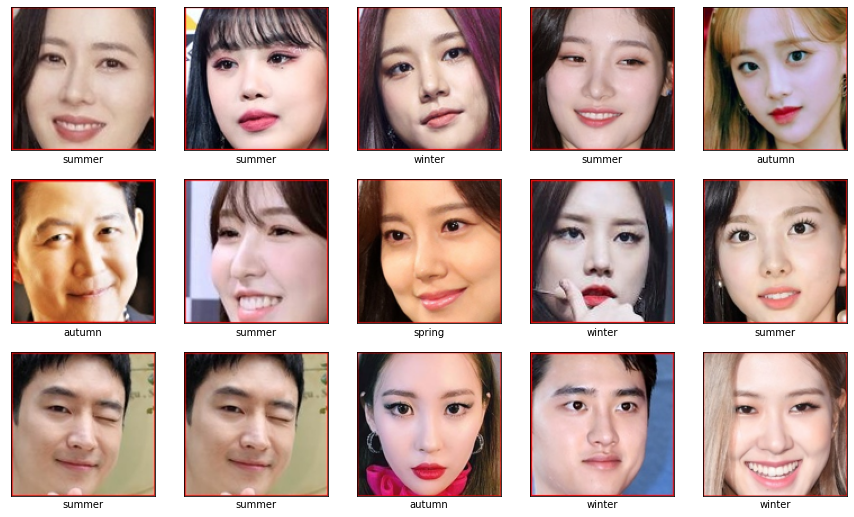

In [ ]:
# data 확인
plt.figure(figsize=(15,9))
for i in range(15):
  img_idx = np.random.randint(0,635)
  plt.subplot(3,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[img_idx])
  plt.xlabel(categories[train_labels[img_idx][0]])

In [ ]:
# pixel값을 0~1사이 범위로 조정

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [ ]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(635, 128, 128, 3) (635, 4)
(71, 128, 128, 3) (71, 4)


In [ ]:
# 하이퍼 파라미터
learning_rate = 0.01
epochs =15
batch_size = 64
category = 4

In [ ]:
# resnet
model = keras.Sequential()
model.add(ResNet50(include_top=True, weights=None, input_shape=(128, 128, 3), classes=4))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4)                 23595908  
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
Total params: 23,595,928
Trainable params: 23,542,808
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate)) 

In [ ]:
history = model.fit(train_images,train_labels, 
                    batch_size=batch_size, epochs=10,
                    validation_data = (test_images, test_labels))

Epoch 1/10
10/10 [==============================] - 172s 17s/step - loss: 1.3943 - accuracy: 0.2614 - val_loss: 1.3925 - val_accuracy: 0.2254
Epoch 2/10
10/10 [==============================] - 174s 17s/step - loss: 1.3884 - accuracy: 0.2677 - val_loss: 1.3840 - val_accuracy: 0.2254
Epoch 3/10
10/10 [==============================] - 176s 18s/step - loss: 1.3883 - accuracy: 0.2535 - val_loss: 1.3824 - val_accuracy: 0.2254
Epoch 4/10
10/10 [==============================] - 172s 17s/step - loss: 1.3884 - accuracy: 0.2693 - val_loss: 1.3818 - val_accuracy: 0.2254
Epoch 5/10
 1/10 [==>...........................] - ETA: 2:32 - loss: 1.3762 - accuracy: 0.2656

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if (predicted_label == true_label).all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categories[predicted_label],
                                100*np.max(predictions_array),
                                categories[true_label]),
                                color=color)

In [ ]:
# 4개 그래프에 대한 예측 그래프로 표현
def plot_image(i, predictions_array, true_label, img): # 그래프로 표현하는 함수
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if (predicted_label == true_label).all():
     color = 'blue'
  else:
     color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categories[predicted_label],
                                100*np.max(predictions_array),
                                categories[true_label]),
                                color=color)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(batch_size)

In [ ]:
def plot_value_array(i, predictions_array, true_label): #
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(range(4), categories, rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

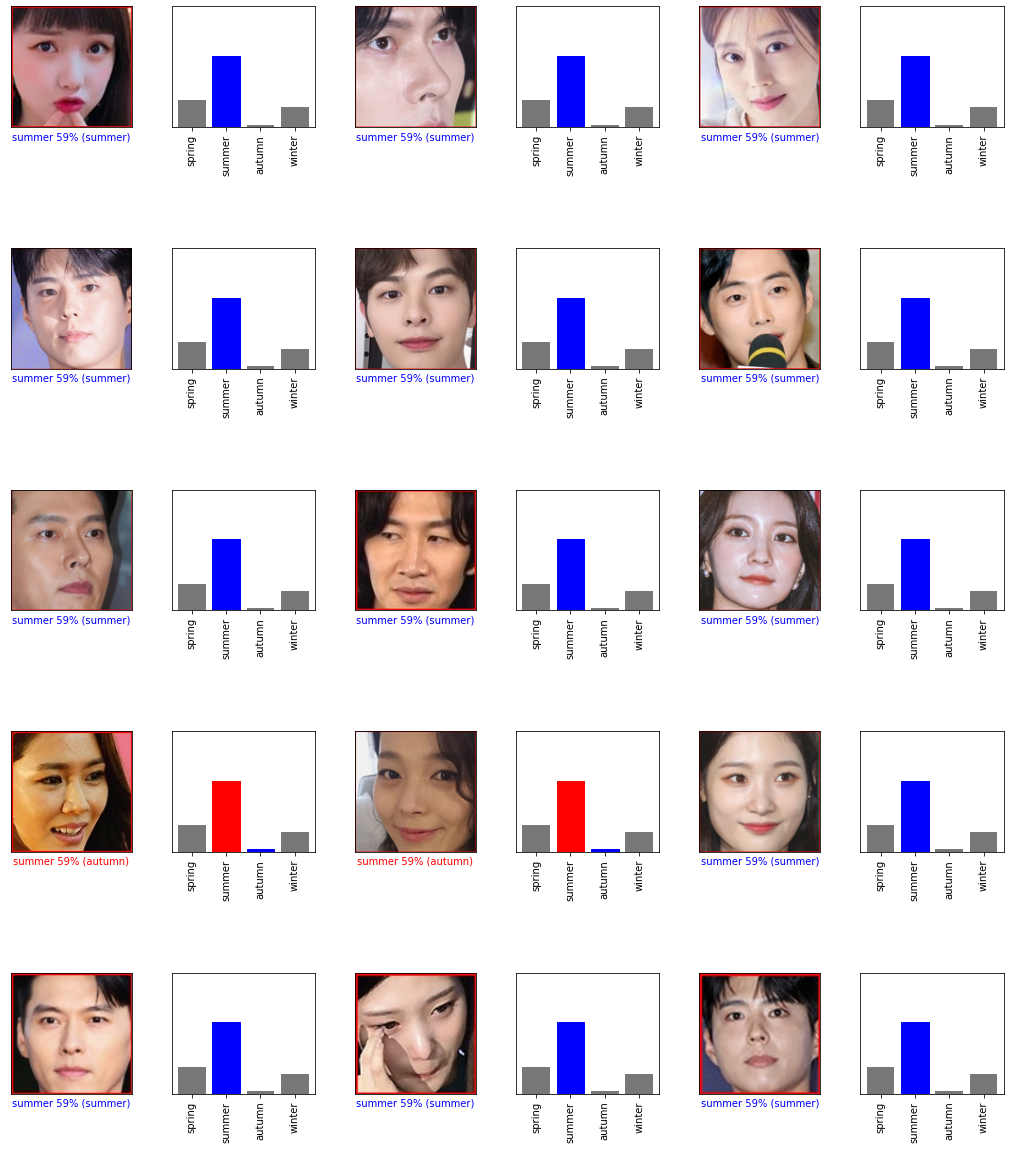

In [ ]:
# plt.subplot - 한개의 화면에 여러 그래프 나눠 그리기
# 파랑색 - 올바른 예측
# 빨강색 - 잘못된 예측
rnd_idx = np.random.randint(1,len(test_images)//batch_size)
img_cnt = 0  
for images, labels in test_dataset:
  img_cnt +=1
  if img_cnt != rnd_idx:
    continue
  predictions = model(images, training=False)
  num_rows = 5
  num_cols = 3
  num_images = num_rows*num_cols 
  labels = tf.argmax(labels, axis=-1)
  plt.figure(figsize=(3*2*num_cols, 4*num_rows))
  plt.subplots_adjust(hspace=1.0)
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions.numpy(), labels.numpy())
  break

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=keras.utils.load_img(path, target_size=(128, 128))

  x=keras.utils.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=batch_size)
  for i in range(0,4,1) :
    print(categories[i], "=", classes[0][i])
  print("예측한 결과 = " , categories[classes.argmax()])

Saving winter12.jpg to winter12.jpg
1/1 [==============================] - 0s 109ms/step
spring = 0.22166584
summer = 0.5902531
autumn = 0.022794032
winter = 0.16528699
예측한 결과 =  summer
